In [7]:
import dolfinx as dlx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from ls_prior import builder
from mpi4py import MPI

from cardiac_electrophysiology.utils import data_processing as dp

sns.set_theme(style="ticks")

In [8]:
mesh = dlx.mesh.create_rectangle(
    MPI.COMM_WORLD,
    [np.array([0, 0]), np.array([1, 1])],
    [100, 100],
    dlx.mesh.CellType.triangle,
)
vertices = mesh.geometry.x
simplices = mesh.geometry.dofmap
simplex_to_vertex_matrix = dp.assemble_simplex_to_vertex_interpolation_matrix(simplices)

mean_angle_vector = np.full(simplices.shape[0], np.pi / 4)
mean_angle_vector = simplex_to_vertex_matrix @ mean_angle_vector
mean_parameter_vector = np.arctanh(np.cos(mean_angle_vector + np.pi / 2))

In [13]:
prior_settings = builder.BilaplacianPriorSettings(
    mesh=mesh,
    mean_vector=mean_parameter_vector,
    kappa=50,
    tau=0.01,
)

prior_builder = builder.BilaplacianPriorBuilder(prior_settings)
bilaplace_prior = prior_builder.build()

In [14]:
num_samples = 1000
angle_samples = []
for _ in range(num_samples):
    parameter_sample = bilaplace_prior.generate_sample()
    centered_parameter_sample = parameter_sample - mean_parameter_vector
    angle_sample = np.arccos(np.tanh(centered_parameter_sample)) + mean_angle_vector - np.pi / 2
    angle_samples.append(angle_sample)

angle_samples = np.array(angle_samples).T
angle_mean, angle_variance = dp.compute_axial_mean_and_variance(angle_samples, axis=1)

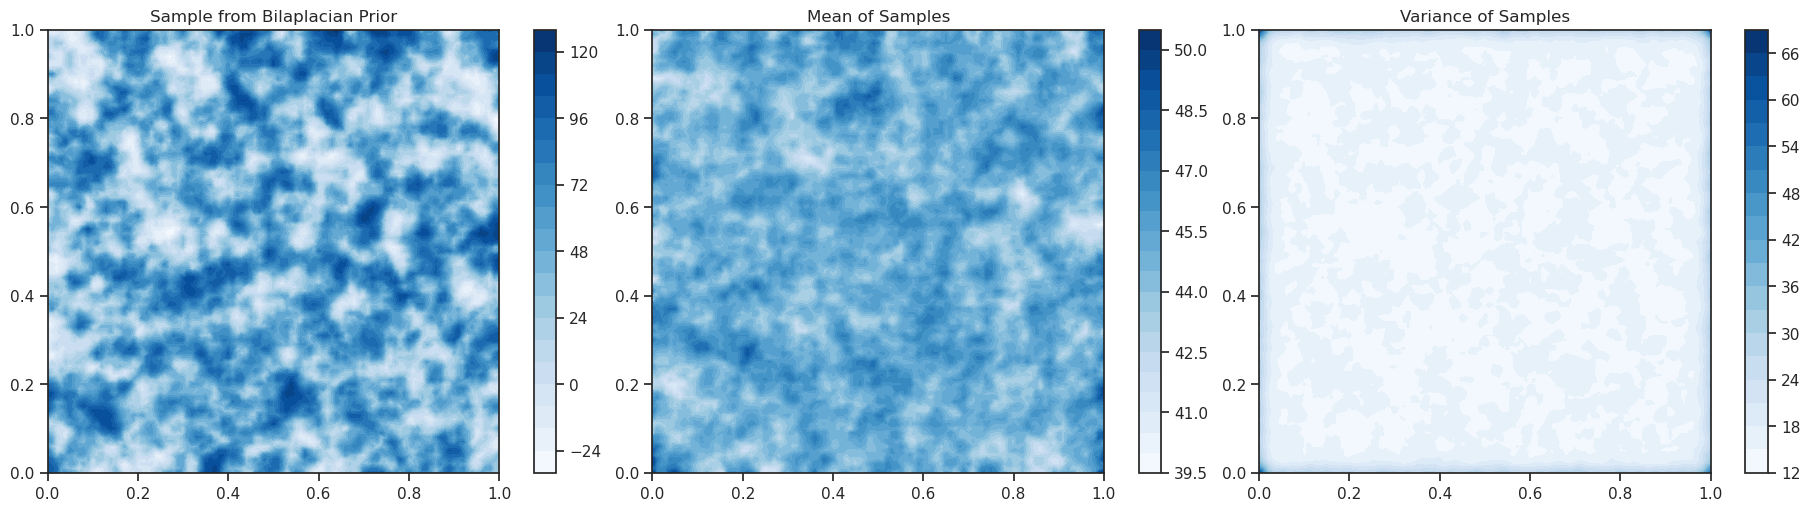

In [15]:
parameter_sample = bilaplace_prior.generate_sample()
centered_parameter_sample = parameter_sample - mean_parameter_vector
angle_sample = np.arccos(np.tanh(centered_parameter_sample)) + mean_angle_vector - np.pi / 2

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), layout="constrained")
contour_plot = axs[0].tricontourf(
    vertices[:, 0], vertices[:, 1], np.degrees(angle_sample), levels=20, cmap="Blues"
)
plt.colorbar(contour_plot, ax=axs[0])
contour_plot = axs[1].tricontourf(
    vertices[:, 0], vertices[:, 1], np.degrees(angle_mean), levels=20, cmap="Blues"
)
plt.colorbar(contour_plot, ax=axs[1])
contour_plot = axs[2].tricontourf(
    vertices[:, 0], vertices[:, 1], np.degrees(angle_variance), levels=20, cmap="Blues"
)
plt.colorbar(contour_plot, ax=axs[2])
axs[0].set_title("Sample from Bilaplacian Prior")
axs[1].set_title("Mean of Samples")
axs[2].set_title("Variance of Samples")
plt.show()

Text(0, 0.5, 'Density')

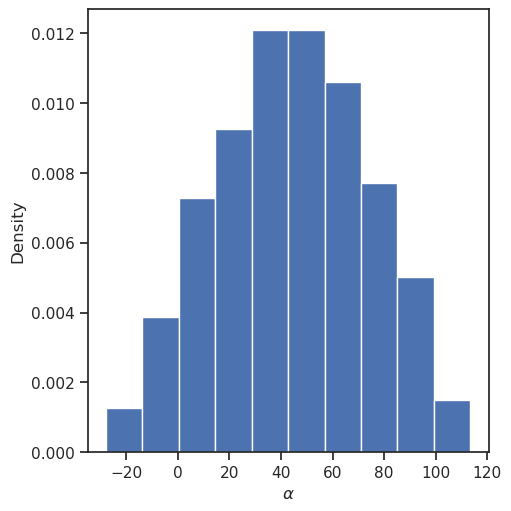

In [21]:
test_point = 200
point_samples = angle_samples[test_point, :]

fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")
_ = ax.hist(np.degrees(point_samples), bins=10, density=True)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("Density")